# recreate validation df

In [42]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'



# plotting settings

In [113]:
from matplotlib import pyplot as plt

# create style sheet?
# plt.style.use('./styles/sam.mplstyle')

small_txt = 7
med_txt = 8
big_txt = 8
# set text sizes
plt.rcParams['font.size'] = small_txt
plt.rcParams['axes.labelsize'] = med_txt
plt.rcParams['axes.titlesize'] = big_txt
plt.rcParams['xtick.labelsize'] = small_txt
plt.rcParams['ytick.labelsize'] = small_txt
plt.rcParams['legend.fontsize'] = med_txt
plt.rcParams['figure.titlesize'] = big_txt
# opaque legend (<1 is not fully opaque)
plt.rcParams["legend.framealpha"] = 1.0
# set figure size
plt.rcParams['figure.figsize']=[6,2.5]
plt.rcParams['figure.dpi'] = 300
# set default font
# plt.rcParams['font.sans-serif'] = "Gill Sans"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "gillsans"


# TIP use these 2 lines to list all available fonts:
# from matplotlib import font_manager
# font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# to add a font
# on linux, add .ttf font files to /usr/share/fonts/truetype/
# then follow these instructions https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html 

# tell matplotlib to create vector fonts 
# so you can edit them later! eg in Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plt.rcParams['lines.markersize'] = 1


#color and line style cycles #
# TIP: use https://coolers.co to create nice color palettes
#or modify this one https://coolors.co/35aad8-f3b61f-ba3b54-45b69c-8a96d7
from cycler import cycler
default_cycler = (cycler(color=['#35aad8','#f3b61f','#8a96d7','#45b69c','#ba3b54']) 
                  # + cycler(linestyle=['-', '--', '-.', ':','-'])
                 )
plt.rc('lines', linewidth=0.5)
plt.rc('axes', prop_cycle=default_cycler)

#use appropriate resolution for retina screens
%config InlineBackend.figure_format='retina'

In [114]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from opensoundscape.torch.models.cnn import CNN
from opensoundscape.preprocess.preprocessors import SpectrogramPreprocessor
from opensoundscape.data_selection import resample
import wandb

name = 'm2'

# Train on A and V classes, excluding X class

labels = pd.read_csv('/media/emu/datasets/labeled/ramu_10s_msd0558/labels_2s.wav')

#choose training and validation labels
labels['ramu']=np.logical_or(labels.A,labels.V).astype(int)

# drop clips with 0 for ramu and 1 for 'X' unsure class
labels = labels.drop(labels[(labels.ramu==0) & (labels.X==1)].index)


from sklearn.model_selection import train_test_split

train_files,val_files = train_test_split(labels.audio_file.unique(),test_size=0.1,random_state=20221208)

labels=labels.rename(columns={'audio_file':'file'})
labels = labels.set_index('file')
train_df = labels.loc[train_files]
val_df = labels.loc[val_files]

train_df = train_df.reset_index().set_index(['file','start_time','end_time'])[['ramu']]
train_df['negative']=1-train_df.ramu
val_df = val_df.reset_index().set_index(['file','start_time','end_time'])[['ramu']]
val_df['negative']=1-val_df.ramu

load csv instead of re-creating scores

In [115]:
# from opensoundscape.torch.models.cnn import load_model
# model = load_model('/media/emu/projects/sml161/ecco12_ramu/trained_models/m2/best.model')


In [116]:
#scores,_,_ = model.predict(samples=val_df.reset_index().file.values,batch_size=128)

In [117]:
scores = pd.read_csv('./m2_validation_preds.csv')

In [118]:
scores.head()

,file,start_time,end_time,ramu,negative
0,/media/emu/datasets/labeled/ramu_10s_msd0558/c...,0.0,2.0,-2.104445,1.695426
1,/media/emu/datasets/labeled/ramu_10s_msd0558/c...,0.5,2.5,-1.770301,1.602344
2,/media/emu/datasets/labeled/ramu_10s_msd0558/c...,1.0,3.0,-2.209821,1.728228
3,/media/emu/datasets/labeled/ramu_10s_msd0558/c...,1.5,3.5,-1.620319,1.266714
4,/media/emu/datasets/labeled/ramu_10s_msd0558/c...,2.0,4.0,-2.055916,1.741811


In [119]:
from torch import softmax, tensor

In [120]:
scores['softmax']=softmax(tensor(scores[['ramu','negative']].values),1)[:,0].numpy()

In [121]:
scores.to_csv('./m2_validation_preds_w_softmax.csv')

In [122]:
scores = scores.set_index(['file','start_time','end_time'])

In [123]:
val_df['score']=scores['softmax']

In [124]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc

In [125]:
len(val_df)

1111

In [126]:
len(scores)

1139

In [127]:
p,r,t = precision_recall_curve(val_df.ramu,val_df.score)

In [128]:
print(f"Average precision: {average_precision_score(val_df.ramu,val_df.score)}")
print(f"Area under ROC curve: {roc_auc_score(val_df.ramu,val_df.score)}")
print(f"Area under P-R curve: {auc(r,p)}")

Average precision: 0.9221555512643238
Area under ROC curve: 0.9533535862797061
Area under P-R curve: 0.9220479278748017


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
too much 'glyf' table data: expected 42820, received 42914 bytes
too much 'hmtx' table data


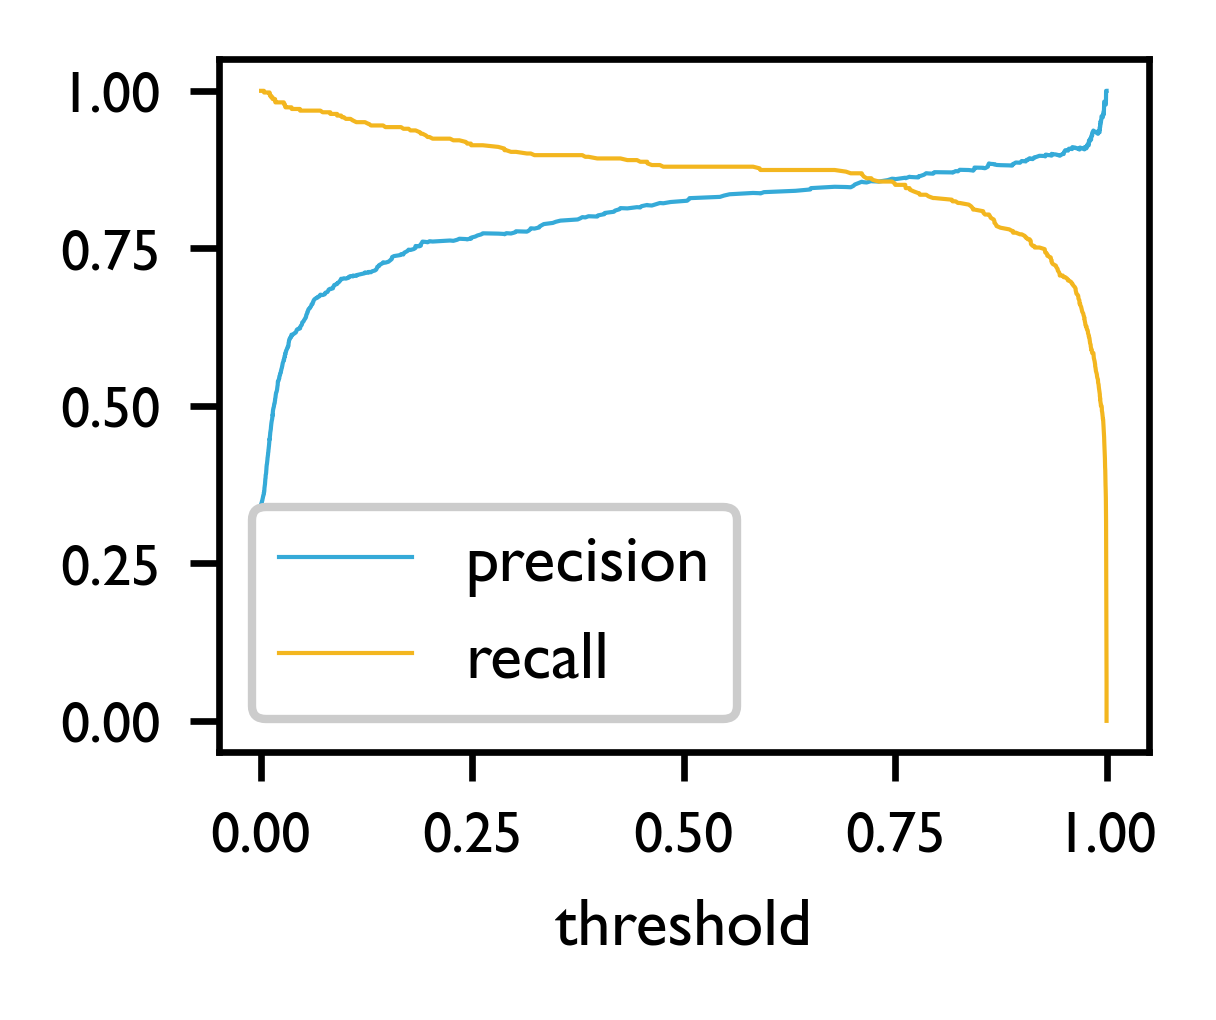

In [137]:
plt.figure(figsize=(2,1.5)) 

plt.plot(t,p[1:],label='precision')
plt.plot(t,r[1:],label='recall')
# plt.xlim([0.9,1])
plt.xlabel('threshold')
plt.legend()
# ax plt.semilogx()
plt.savefig('./figures/precision_recall_curve.pdf')

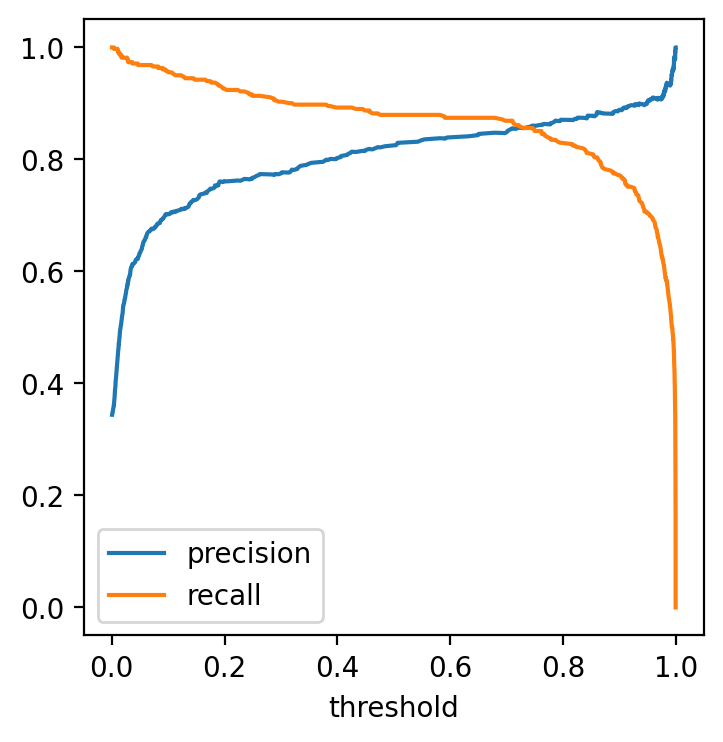

In [89]:
# plt.figure(figsize=(4,4)) 

# plt.plot(t,p[1:],label='precision')
# plt.plot(t,r[1:],label='recall')
# # plt.xlim([0.9,1])
# plt.xlabel('threshold')
# plt.legend()
# plt.savefig('./figures/precision_recall.pdf')
# # ax plt.semilogx()

In [84]:
sampled_p_r = pd.DataFrame({'precision':p[1:],'recall':r[1:],'threshold':t})
sampled_p_r[-150:-130]

,precision,recall,threshold
961,0.979866,0.382199,0.998715
962,0.979730,0.379581,0.998726
963,0.979592,0.376963,0.998769
964,0.979452,0.374346,0.998789
965,0.979310,0.371728,0.998878
966,0.979167,0.369110,0.998938
967,0.979021,0.366492,0.998962
968,0.978873,0.363874,0.998977
969,0.978723,0.361257,0.998983
970,0.978571,0.358639,0.999036


In [57]:
first_threshold_w_prec09 = np.argmax((p>0.9)[1:]) + 1
print(t[first_threshold_w_prec09])
print(p[first_threshold_w_prec09])
print(r[first_threshold_w_prec09])

0.951152894590633
0.9026845637583892
0.7041884816753927


In [59]:
first_threshold_w_prec095 = np.argmax((p>0.95)[1:]) + 1
print(t[first_threshold_w_prec095])
print(p[first_threshold_w_prec095])
print(r[first_threshold_w_prec095])

0.9928882085210652
0.9509803921568627
0.5078534031413613


# We choose the threshold 0.99933 for the manuscript, for >99% precision

In [85]:
first_threshold_w_prec099 = np.argmax((p>0.99)[1:]) + 1
print(t[first_threshold_w_prec099])
print(p[first_threshold_w_prec099])
print(r[first_threshold_w_prec099])

0.9993342085091393
0.9923664122137404
0.3403141361256545


In [142]:
from torch import logit, sigmoid
logit(tensor(0.992882))

tensor(4.9380)

In [86]:
logit(tensor(0.9993342))

tensor(7.3139)

## precision and recall at thresholds shown in figures

In [158]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score

In [153]:
float(sigmoid(thresholds[0]))

0.7069873809814453

In [156]:
t

10

0.8820058997050148

In [163]:
thresholds = [0,2,4,6,8,10]
for t in thresholds:
    th = float(sigmoid(tensor(t)))
    print(f"threshold: {t} prec {precision_score(val_df.ramu, (val_df.score>th))} rec {recall_score(val_df.ramu, (val_df.score>th))}")

threshold: 0 prec 0.8235294117647058 rec 0.8795811518324608
threshold: 2 prec 0.8820058997050148 rec 0.7827225130890052
threshold: 4 prec 0.9259259259259259 rec 0.5890052356020943
threshold: 6 prec 0.9821428571428571 rec 0.4319371727748691
threshold: 8 prec 1.0 rec 0.25654450261780104
threshold: 10 prec 1.0 rec 0.14659685863874344
